# Evaluating the performance of Gradient Descent and Newton’s methods on Logistic Regression Problems

The following is a project aiming to compare the performance of two of the most important methods used in the context of optimization for machine learning: Gradient Descent and Newton's method.

It will mainly consist on implementing classes and functions allowing to load data to build an instance of logistic regression problem with ℓ2-regularization, compute the loss, its gradient and the Hessian.

Then, both methods will be implemented, the GD method will also implement the Armijo rule to update the learning rate.

In [3]:
import time
import random
import urllib.request
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.datasets import load_svmlight_file

# First I define the functions to calculate the gradient and hessian

In [ ]:
def calculate_gradient(y, X, params):
    n = X.shape[0]

    w = params[:-1]  # weights
    b = params[-1]   # bias

    z = (X @ w + b)
    z = np.clip(z, -500, 500)

    sig = 1 / (1 + np.exp(-z))

    error = sig - y

    grad_w = (X.T @ error)/ n + .1 * w
    grad_b = np.sum(error)/ n

    grad = np.append(grad_w, grad_b)

    return grad

def calculate_hessian(y, X, params):
    n = X.shape[0]

    w = params[:-1]
    b = params[-1]

    z = X @ w + b
    mu = 1 / (1 + np.exp(-z))  # sigmoid(z)
    D = mu * (1 - mu)          # shape (n,)

    DX = X * D[:, np.newaxis]

    H_w = (X.T @ DX) / n + .1 * np.eye(len(w))
    H_wb = np.sum(DX, axis=0) / n
    H_b = np.sum(D) / n

    # Assemble the full Hessian matrix
    H_top = np.hstack([H_w, H_wb[:, np.newaxis]])
    H_bottom = np.append(H_wb, H_b)[np.newaxis, :]
    H = np.vstack([H_top, H_bottom])

    return H

This loss computation will be useful to iterate over Armijo's rule for GD calculation.

It's different from the one to be optimized later on, as this must be evaluated on different points to evaluate Armijo's rule.

In [ ]:
def compute_loss(X, y, params, w_decay=0.1):
    n_samples = X.shape[0]
    w = params[:-1]
    b = params[-1]

    # Compute logits and clip to avoid overflow
    z = X @ w + b
    z = np.clip(z, -500, 500)
    y_pred = 1 / (1 + np.exp(-z))

    # Compute loss
    loss = -(1 / n_samples) * np.sum(
        y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8)
    )

    # L2 regularization term
    loss_l2 = loss + (w_decay / (2 * n_samples)) * np.sum(w**2)


    return loss_l2


# Then, I define the functions for the GD method and the Newton method

In [ ]:
def gradient_descent1(y, X, loss_func, params, lr, max_iter= 200, threshold= 1e-6):

  params = np.concatenate([params[0].flatten(), [params[1]]])
  learning_rate = lr

  #evaluate the first gradient
  grad = calculate_gradient(y, X, params)

  #Parameters for Armijo rule. These can be toggled with to compare results
  gamma = 1e-4
  delta = .8
  w_decay = .1

  for i in range(max_iter):

    #Armijo's rule
    lr = learning_rate
    dk = -grad

    lhs = compute_loss(X, y, params + lr * dk, w_decay)
    rhs = compute_loss(X, y, params, w_decay) - gamma * lr * np.linalg.norm(grad)**2   #- gamma * lr * (grad @ dk)

    #lhs = loss_func(params + lr * dk)
    #rhs = loss_func(params) - gamma * lr * np.linalg.norm(grad)**2 #+ gamma * lr * (grad @ dk)

    backtracks = 0
    max_backtracks = 20

    while lhs > rhs and backtracks < max_backtracks:
        lr *= delta
        lhs = loss_func(params + lr * dk)
        backtracks += 1


    #GD formula
    params -= lr * grad

    #Stoppage criteria
    if np.linalg.norm(grad) < threshold:
        print(f"Converged in {i+1} iterations.")
        return params, i+1

    grad = calculate_gradient(y, X, params)

  print(f"Done in {i+1} iterations.")
  return params, i+1

In [ ]:
def newton_method1(y, X, params, max_iter= 200, tolerance= 1e-6):

  params = np.concatenate([params[0].flatten(), [params[1]]])

  grad = calculate_gradient(y, X, params)
  hessian = calculate_hessian(y, X, params)

  for i in range(max_iter):
    if np.linalg.det(hessian) == 0:
      print("Hessian is singular. Newton's method cannot proceed.")
      print(f"Done in {i+1} iterations.")
      break

    #Newton's Method formula
    params_new = params - np.linalg.inv(hessian).dot(grad)
    params = params_new

    # Re-evaluate the gradient and hessian at the new point
    grad = calculate_gradient(y, X, params)
    hessian = calculate_hessian(y, X, params)


    #Stoppage criteria. Either the gradient's norm below a threshold, or Hessian singularity
    if (np.linalg.norm(grad) < tolerance):
        print(f"Converged in {i+1} iterations.")
        return params_new, i+1

  return params, i+1 # Return params even if not converged

# Logistic Regression class

This class must give the user the choice for either method

In [ ]:
class LogisticRegression:

  def __init__(self, lr=1.1, n_iters=1000):
    self.lr = lr
    self.n_iters = n_iters
    self.weights = None
    self.bias = None
    self.iterations = None

  def fit(self, X, y, opt):

    #We scale the X vector
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    #Separate the amount of features and samples
    n_samples, n_features = X.shape

    self.weights = np.random.randn(n_features) * 0.1 #small random values
    self.bias = random.random() * .01 #to initialize our point of search

    #We store our params in a vector
    params = [self.weights, self.bias]

    #Loss function: BCE with L2 regularization
    def loss_func(params):
        weights = params[:-1].reshape(n_features)
        bias = params[-1]

        linear_model = np.dot(X, weights) + bias
        y_pred = self.sigmoid(linear_model)
        w_decay = .1

        loss = -(1 / n_samples) * np.sum(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1.e-8))
        loss_l2 = loss + w_decay * np.sum(np.square(weights))
        return loss_l2  # Return the calculated loss

    #We can now implement the optimizer of our choice

    if opt.lower() == "gd":
      params, iterations = gradient_descent1(y, X, loss_func, params, self.lr)
    elif opt.lower() == "newton":
      params, iterations = newton_method1(y, X, params)

    self.weights = params[:-1].reshape(n_features)
    self.bias = params[-1]
    self.iterations = iterations

  def predict(self, X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    linear_model = np.dot(X, self.weights) + self.bias
    y_pred = self.sigmoid(linear_model)
    y_pred_cls = [1 if i >= 0.5 else 0 for i in y_pred]
    return np.array(y_pred_cls), self.iterations

  def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -100, 100)))

# How to test?

In [ ]:
#Store the class into a re-usable variable

regressor = LogisticRegression()

#This measures the accuracy

def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred) / len(y_true)
  return accuracy

The pipeline for each dataset goes as follows:


1.   Load the dataset and split it
2.   Calculate the predictions with the method to evaluate
3.   Print its accuracy, store it (along with other pertinent variables) in a pd dataframe to plot later, then repeat with the next method or dataset

In [ ]:
#With the following dataframes, we will measure the accuracy and time taken by each method for each dataset

results_gd = pd.DataFrame(columns=['dataset_size', 'GD_accuracy', 'GD_time', "GD_iterations"])
results_newton = pd.DataFrame(columns=['dataset_size', 'Newton_accuracy', 'Newton_time', "Newton_iterations"])

Let's wrap this pipeline into a single function for future simplicity!

In [ ]:
def datafit(x_vector, y_labels, opt):
  global results_gd, results_newton
  #Split
  X_train, X_test, y_train, y_test = train_test_split(x_vector, y_labels, test_size=0.2)

  #Calculate
  start_time = time.time()
  #train the regressor with the train vectors
  regressor.fit(X_train, y_train, opt)
  #compute predictions from the test vector
  predictions, iterations= regressor.predict(X_test)
  end_time = time.time()

  time_taken = end_time - start_time

  #y_test is equal to the true label, while predictions are y_pred
  acc = accuracy(np.array(y_test), predictions)

  if opt.lower() == "gd":

   results_gd = pd.concat([results_gd, pd.DataFrame([{
    'dataset_size': X_train.shape[1],
    'GD_accuracy': acc,
    'GD_time': time_taken,
    "GD_iterations": iterations
      }])], ignore_index=True)

  elif opt.lower() == "newton":

   results_newton = pd.concat([results_newton, pd.DataFrame([{
    'dataset_size': X_train.shape[1],
    'Newton_accuracy': acc,
    'Newton_time': time_taken,
    "Newton_iterations": iterations
      }])], ignore_index=True)


  print(f"LR classification accuracy with {opt} is:", acc)

# Now come the datasets

I'll start with the datasets w4a and a2a. Since these are found in a website, they will be loaded with a url.

In [1]:
#Load a2a dataset

url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a2a"
save_path = "a2a.txt"

urllib.request.urlretrieve(url, save_path)
print("Dataset downloaded and saved as", save_path)

#Load w4a dataset

url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w4a"
save_path = "w4a.txt"

urllib.request.urlretrieve(url, save_path)
print("Dataset downloaded and saved as", save_path)


Dataset downloaded and saved as a2a.txt
Dataset downloaded and saved as w4a.txt


First, in the a2a dataset I map the -1's (negative label) to 0's, so that my logistic regression can mathematically work.

In [5]:
X, y = load_svmlight_file("a2a.txt")

#We map the -1's to 0's, otherwise the math won't make sense and the algorithms won't work
y = (y == 1).astype(int)

#I convert the dataframe to a numpy array
df = pd.DataFrame(X.toarray())
df['target'] = y
df.to_csv("a2a.csv", index=False)

a2a = pd.read_csv("a2a.csv")
a2a = a2a.dropna()
samples, features = a2a.shape

print(samples, features)


2265 120


In [6]:
#Load each vector
X = a2a.drop(columns=["target"]).select_dtypes(include=np.number).values
y = a2a["target"].values

#This snippet will tell us how class-balanced the dataset is
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

#And here we call the datafit function to do the whole process. We will test the GD method
datafit(X, y, "GD")

{np.int64(0): np.int64(1693), np.int64(1): np.int64(572)}


NameError: name 'datafit' is not defined

In [ ]:
#We restart X and y so that our model re-learns and is tested again on Newton's method
X = a2a.drop(columns=["target"]).select_dtypes(include=np.number).values
y = a2a["target"].values

datafit(X, y, "newton")

Converged in 6 iterations.
LR classification accuracy with newton is: 0.8123620309050773


/tmp/ipython-input-146-639344508.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_newton = pd.concat([results_newton, pd.DataFrame([{


We repeat the same process for the w4a dataset

In [ ]:
X, y = load_svmlight_file("w4a.txt")

#We map the -1's to 0's, otherwise the math won't make sense and the algorithms won't work
y = (y == 1).astype(int)

df = pd.DataFrame(X.toarray())
df['target'] = y
df.to_csv("w4a.csv", index=False)

w4a = pd.read_csv("w4a.csv")
w4a = w4a.dropna()
samples, features = w4a.shape

print(samples, features)

7366 301


In [ ]:
#Load
X = w4a.drop(columns=["target"]).select_dtypes(include=np.number).values
y = w4a["target"].values

#This snippet will tell us how class-balanced the dataset is
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

datafit(X, y, "GD")

Done in 200 iterations.
LR classification accuracy with GD is: 0.9728629579375848


In [ ]:
#Load
X = w4a.drop(columns=["target"]).select_dtypes(include=np.number).values
y = w4a["target"].values

datafit(X, y, "newton")

LR classification accuracy with newton is: 0.9715061058344641


# First dataset: BC

In [ ]:
#Load

bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

#This snippet will tell us how class-balanced the dataset is
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

datafit(X, y, "GD")

Done in 200 iterations.
LR classification accuracy with GD is: 0.9912280701754386


62-48 class balance

In [ ]:
X, y = bc.data, bc.target

datafit(X, y, "Newton")

Converged in 5 iterations.
LR classification accuracy with Newton is: 0.9210526315789473


# Second dataset: Car accident survival

In [ ]:
car_acc = pd.read_csv("accident.csv")
car_acc = car_acc.dropna()
samples, features = car_acc.shape

print(samples, features)

196 6


In [ ]:
car_acc = car_acc.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)
car_acc.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,0,27.0,0,0,1
1,69,0,46.0,0,1,1
2,46,1,46.0,1,1,0
3,32,1,117.0,0,1,0
4,60,0,40.0,1,1,0


In [ ]:
#Load
X, y = car_acc.drop(columns=["Survived"]), car_acc["Survived"]

#Check for class balance
class_distribution = y.value_counts(normalize=True) * 100
print(class_distribution)

datafit(X, y, "GD")

Converged in 30 iterations.
LR classification accuracy with GD is: 0.7


51-49 class balance

In [ ]:
X, y = car_acc.drop(columns=["Survived"]), car_acc["Survived"]

datafit(X, y, "Newton")

Converged in 3 iterations.
LR classification accuracy with Newton is: 0.475


# Third dataset: Twitter bot detection

I got to the conclusion that this dataset is not meant for logistic regression, as most of the features are non-numerical (such as username, location, hashtags) and therefore won't contribute to the learning of a logistic regression algorithm

In [ ]:
twitter = pd.read_csv("bot_detection_data.csv")
twitter = twitter.dropna()

#For this dataset I tried to cut off some features I considered irrelevant
twitter = twitter.drop(columns=["User ID", "Username", "Tweet", "Location", "Created At", "Hashtags"])
twitter = twitter.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)
twitter['Verified'] = twitter['Verified'].astype(int)

twitter.head()

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label
1,55,5,9617,1,0
2,6,2,4363,1,0
3,54,5,2242,1,1
4,26,3,8438,0,1
5,41,4,3792,1,1


In [ ]:
#Load
X, y = twitter.drop(columns=["Bot Label"]), twitter["Bot Label"]

#Check for class balance
class_distribution = y.value_counts(normalize=True) * 100
print(class_distribution)

datafit(X, y, "GD")

Converged in 25 iterations.
LR classification accuracy with GD is: 0.5025204032645223


Almost 50-50 balanced class

In [ ]:
X, y = twitter.drop(columns=["Bot Label"]), twitter["Bot Label"]

datafit(X, y,"newton")

Converged in 2 iterations.
LR classification accuracy with newton is: 0.49891982717234756


# Fourth dataset: Diabetes

In [ ]:
diabetes = pd.read_csv("diabetes2.csv")
diabetes = diabetes.dropna()
diabetes = diabetes.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
X, y = diabetes.drop(columns=["Outcome"]), diabetes["Outcome"]

class_distribution = y.value_counts(normalize=True) * 100
print(class_distribution)

datafit(X, y, "GD")

65.1-34.89% balance

In [ ]:
X, y = diabetes.drop(columns=["Outcome"]), diabetes["Outcome"]
datafit(X, y, "Newton")

Converged in 4 iterations.
LR classification accuracy with Newton is: 0.8051948051948052


# Dataset 5: Heart Disease

In [ ]:
heart = pd.read_csv("heart_disease.csv")
heart = heart.dropna()
heart = heart.drop(columns = ["education"])
heart = heart.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

heart.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
X, y = heart.drop(columns=["TenYearCHD"]), heart["TenYearCHD"]

class_distribution = y.value_counts(normalize=True) * 100
print(class_distribution)

datafit(X, y, "GD")

Converged in 94 iterations.
LR classification accuracy with GD is: 0.8620218579234973


Class balance: 84.76-15.23%

In [ ]:
X, y = heart.drop(columns=["TenYearCHD"]), heart["TenYearCHD"]

datafit(X, y, "Newton")

Converged in 4 iterations.
LR classification accuracy with Newton is: 0.8469945355191257


# Dataset 6: Loan Approval

In [ ]:
loan_approval = pd.read_csv("loan_data.csv")
loan_approval = loan_approval.dropna()
loan_approval = loan_approval.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

loan_approval.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,4,71948.0,0,3,35000.0,4,16.02,0.49,3.0,561,0,1
1,21.0,0,3,12282.0,0,2,1000.0,1,11.14,0.08,2.0,504,1,0
2,25.0,0,3,12438.0,3,0,5500.0,3,12.87,0.44,3.0,635,0,1
3,23.0,0,1,79753.0,0,3,35000.0,3,15.23,0.44,2.0,675,0,1
4,24.0,1,4,66135.0,1,3,35000.0,3,14.27,0.53,4.0,586,0,1


In [ ]:
X, y = loan_approval.drop(columns=["loan_status"]), loan_approval["loan_status"]

class_distribution = y.value_counts(normalize=True) * 100
print(class_distribution)

datafit(X, y, "GD")

This dataset has a 77.77-22.22 balance between classes

In [ ]:
X, y = loan_approval.drop(columns=["loan_status"]), loan_approval["loan_status"]

datafit(X, y, "Newton")

Converged in 4 iterations.
LR classification accuracy with Newton is: 0.866


# Dataset 7: Phishing websites

In [ ]:
phishing = pd.read_csv("dataset_phishing1.csv")

#Map outcomes to 0's and 1's
phishing['status'] = phishing['status'].replace({'legitimate': 1, 'phishing': 0})

print(phishing.shape)

11430 89


In [ ]:
X, y = phishing.drop(columns=["status"]), phishing["status"]
X, y = phishing.select_dtypes(include=np.number).values, phishing["status"].values

#Check for class balance
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

datafit(X, y, "GD")

Converged in 99 iterations.
LR classification accuracy with GD is: 0.9951881014873141


This dataset is perfectly balanced, with 5715 positive and 5715 negative instances

In [ ]:
X, y = phishing.drop(columns=["status"]), phishing["status"]
X, y = phishing.select_dtypes(include=np.number).values, phishing["status"]

datafit(X, y, "Newton")

Converged in 5 iterations.
LR classification accuracy with Newton is: 0.9916885389326334


# Plotting the results

First we plot accuracy vs dataset amount of features for both methods

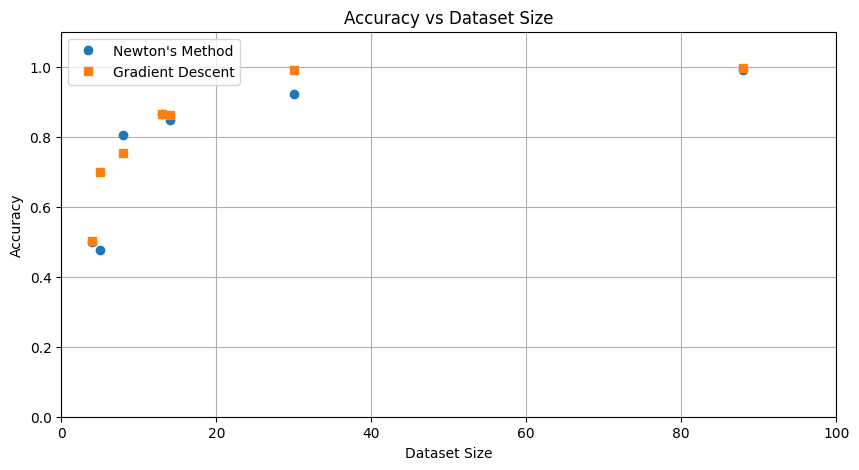

In [ ]:
plt.figure(figsize=(10, 5))

# Plot Newton's Method
plt.plot(results_newton['dataset_size'], results_newton['Newton_accuracy'],
         marker='o', linestyle='None', label="Newton's Method")

# Plot Gradient Descent
plt.plot(results_gd['dataset_size'], results_gd['GD_accuracy'],
         marker='s', linestyle='None', label="Gradient Descent")

plt.xlabel("Dataset Size")
plt.ylabel("Accuracy")
plt.xlim(0, 100)
plt.ylim(0, 1.1)
plt.title("Accuracy vs Dataset Size")
plt.legend()
plt.grid()
plt.show()


Then we plot time vs amount of features

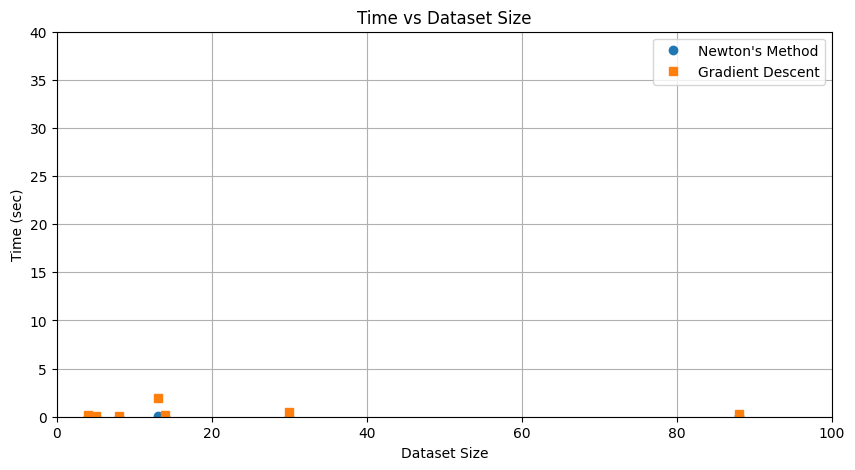

In [ ]:
plt.figure(figsize=(10, 5))

# Plot Newton's Method
plt.plot(results_newton['dataset_size'], results_newton['Newton_time'],
         marker='o', linestyle='None', label="Newton's Method")

# Plot Gradient Descent
plt.plot(results_gd['dataset_size'], results_gd['GD_time'],
         marker='s', linestyle='None', label="Gradient Descent")

plt.xlabel("Dataset Size")
plt.ylabel("Time (sec)")
plt.xlim(0, 100)
plt.ylim(0, 40)
plt.title("Time vs Dataset Size")
plt.legend()
plt.grid()
plt.show()


Iterations vs time taken

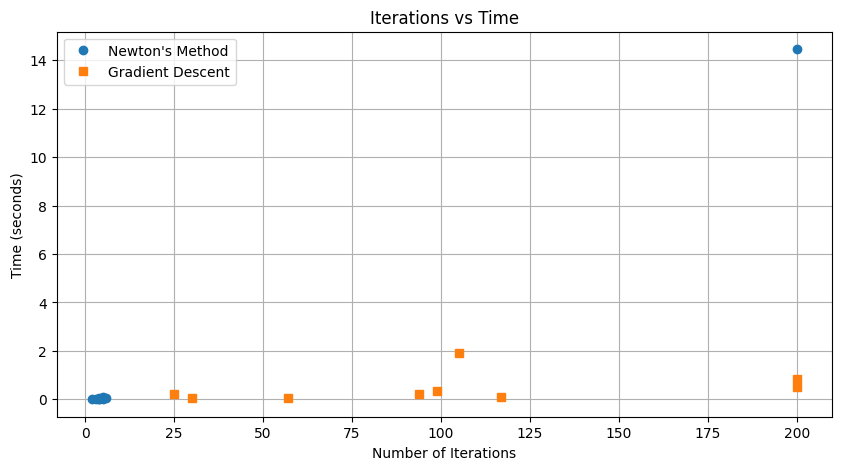

In [ ]:
plt.figure(figsize=(10, 5))

# Newton's Method
plt.plot(results_newton['Newton_iterations'], results_newton['Newton_time'],
         marker='o', linestyle='None', label="Newton's Method")

# Gradient Descent
plt.plot(results_gd['GD_iterations'], results_gd['GD_time'],
         marker='s', linestyle='None', label="Gradient Descent")

plt.xlabel("Number of Iterations")
plt.ylabel("Time (seconds)")
plt.title("Iterations vs Time")
plt.legend()
plt.grid()
plt.show()


Accuracy reached vs iterations required

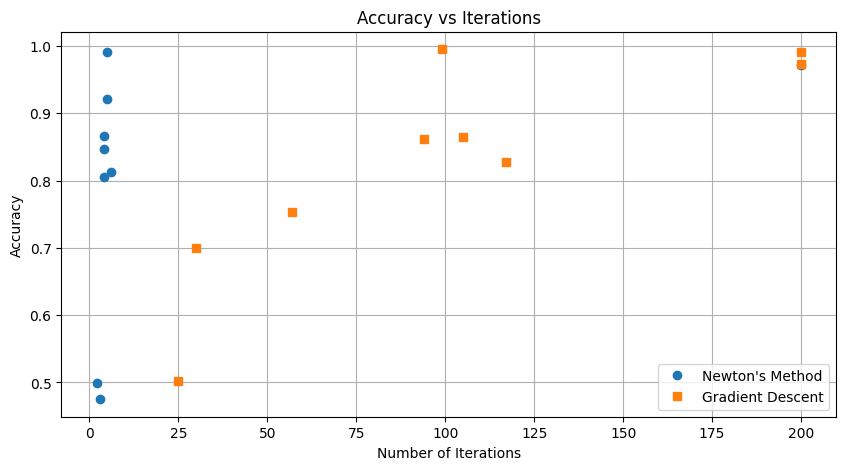

In [ ]:
plt.figure(figsize=(10, 5))

# Newton's Method
plt.plot(results_newton['Newton_iterations'], results_newton['Newton_accuracy'],
         marker='o', linestyle='None', label="Newton's Method")

# Gradient Descent
plt.plot(results_gd['GD_iterations'], results_gd['GD_accuracy'],
         marker='s', linestyle='None', label="Gradient Descent")

plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations")
plt.legend()
plt.grid()
plt.show()


Finally, we plot accuracy vs time taken

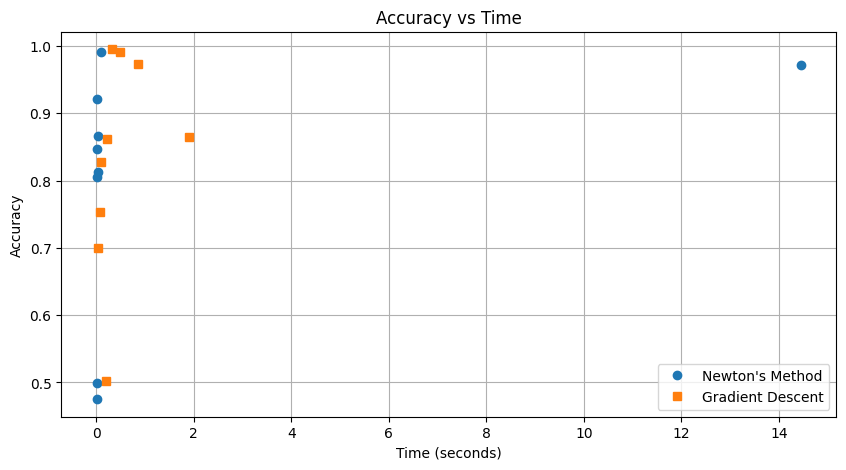

In [ ]:
plt.figure(figsize=(10, 5))

# Newton's Method
plt.plot(results_newton['Newton_time'], results_newton['Newton_accuracy'],
         marker='o', linestyle='None', label="Newton's Method")

# Gradient Descent
plt.plot(results_gd['GD_time'], results_gd['GD_accuracy'],
         marker='s', linestyle='None', label="Gradient Descent")

plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Time")
plt.legend()
plt.grid()
plt.show()
